# gridfinder
Run through the full gridfinder model from data input to final guess for Burundi.
Note that the 'truth' data used for the grid here is very bad, so the accuracy results don't mean much.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import seaborn as sns
from IPython.display import display, Markdown

import numpy as np
import rasterio
import geopandas as gpd

from gridfinder._util import save_raster, clip_line_poly
from gridfinder.prepare import clip_rasters, merge_rasters, create_filter, prepare_ntl, prepare_roads, drop_zero_pop
from gridfinder.gridfinder import get_targets_costs, estimate_mem_use, optimise
from gridfinder.post import threshold, accuracy, guess2geom

## Set folders and parameters

In [3]:
folder = Path('test_data')
folder_inputs = folder / 'inputs'
folder_ntl_in = folder_inputs / 'ntl'
folder_ntl_out = folder / 'ntl_clipped'

aoi_in = folder_inputs / 'gadm.gpkg'
roads_in = folder_inputs / 'roads.gpkg'
pop_in = folder_inputs / 'pop.tif'
grid_truth = folder_inputs / 'grid.gpkg'

raster_merged_out = folder / 'ntl_merged.tif'
targets_out = folder / 'targets.tif'
targets_clean_out = folder / 'targets_clean.tif'
roads_out = folder / 'roads.tif'

dist_out = folder / 'dist.tif'
guess_out = folder / 'guess.tif'
guess_vec_out = folder / 'guess.gpkg'

In [ ]:
percentile = 70  # percentile value to use when merging monthly NTL rasters
threshold = 0.1  # threshold when converting filtered NTL to binary (probably shouldn't change)
upsample_by = 2  # factor by which to upsample before processing roads (both dimensions are scaled by this)
cutoff = 0.5     # cutoff to apply to output dist raster, values below this are considered grid

## Clip  and merge monthly rasters

In [4]:
clip_rasters(folder_ntl_in, folder_ntl_out, aoi_in)

Doing VIIRS_2016_03.tif
Doing VIIRS_2016_09.tif
Doing VIIRS_2016_05.tif
Doing VIIRS_2016_01.tif
Doing VIIRS_2016_04.tif
Doing VIIRS_2016_02.tif
Doing VIIRS_2016_08.tif
Doing VIIRS_2016_11.tif
Doing VIIRS_2016_06.tif
Doing VIIRS_2016_07.tif
Doing VIIRS_2016_12.tif
Doing VIIRS_2016_10.tif


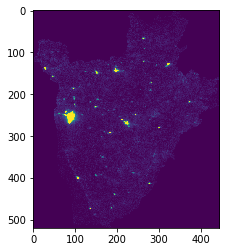

In [5]:
raster_merged, affine = merge_rasters(folder_ntl_out, percentile=percentile)
save_raster(raster_merged_out, raster_merged, affine)
plt.imshow(raster_merged, vmin=0, vmax=1)

## Create filter

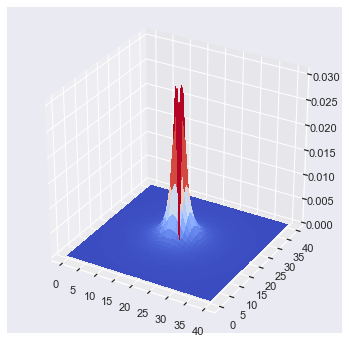

In [6]:
ntl_filter = create_filter()

X = np.fromfunction(lambda i, j: i, ntl_filter.shape)
Y = np.fromfunction(lambda i, j: j, ntl_filter.shape)

fig = plt.figure(figsize=(6,6))
sns.set()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, ntl_filter, cmap=cm.coolwarm, linewidth=0, antialiased=False)

## Clip, filter and resample NTL

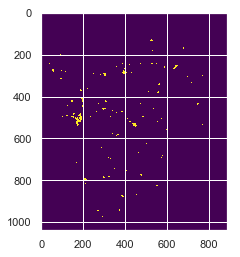

In [7]:
_, _, _, ntl_thresh, affine = prepare_ntl(raster_merged_out,
                                          aoi_in,
                                          ntl_filter=ntl_filter,
                                          threshold=threshold,
                                          upsample_by=upsample_by)
save_raster(targets_out, ntl_thresh, affine)
plt.imshow(ntl_thresh, cmap='viridis')

## Remove target areas with no underlying population

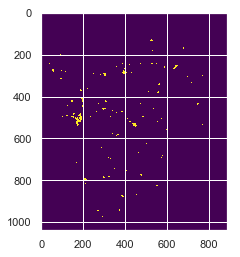

In [8]:
targets_clean = drop_zero_pop(targets_out, pop_in, aoi_in)
save_raster(targets_clean_out, targets_clean, affine)
plt.imshow(ntl_thresh, cmap='viridis')

## Roads: assign values, clip and rasterize

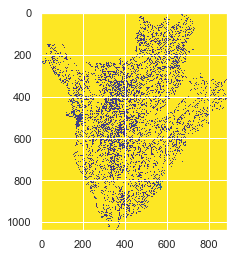

In [9]:
_, _, _, roads_raster, affine = prepare_roads(roads_in,
                                              aoi_in,
                                              targets_out)
save_raster(roads_out, roads_raster, affine)
plt.imshow(roads_raster, cmap='viridis', vmin=0, vmax=1)

## Get targets and costs and run algorithm

In [10]:
targets, costs, start, affine = get_targets_costs(targets_clean_out, roads_out)
est_mem = estimate_mem_use(targets, costs)
print(f'Estimated memory usage: {est_mem:.2f} GB')

Estimated memory usage: 0.02 GB


In [11]:
dist = optimise(targets, costs, start, jupyter=True)

'99.00 %'

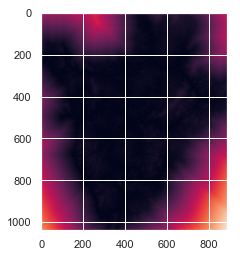

In [12]:
save_raster(dist_out, dist, affine)
plt.imshow(dist)

## Filter dist results to grid guess

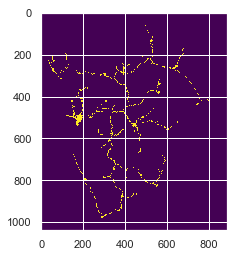

In [13]:
_, guess, transform = threshold(dist_out, cutoff=cutoff)
save_raster(guess_out, guess, transform)
plt.imshow(guess, cmap='viridis')

## Check results

In [14]:
true_pos, false_neg = accuracy(grid_truth, guess_out, aoi_in)
print(f'Points identified as grid that are grid: {100*true_pos:.0f}%')
print(f'Actual grid that was missed: {100*false_neg:.0f}%')

Points identified as grid that are grid: 44%
Actual grid that was missed: 40%


## Convert to geometry
To create line geometry, follow these steps in QGIS using guess.tif created above.
1. Translate (convert format) - Output data type: Int32  
2. r.null - List of values to be set to NULL: 0
3. r.thin - Default values
4. r.to.vect - Feature type: line

/home/chris/.envs/gridfinder/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


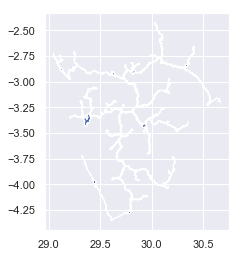

In [15]:
_, _, guess_gdf = guess2geom(guess_out)
guess_gdf.to_file(guess_vec_out, driver='GPKG')
guess_gdf.plot()